In [1]:
import pandas as pd
import numpy as np
from cataclop.ml.pipeline import factories

In [2]:
d = factories.Dataset.factory('default')
d.load(force=True)
d.players.head()

,age,earnings,final_odds,final_odds_ref,handicap_distance,handicap_weight,herder_id,horse_id,imported_at_player,is_first_timer,...,code,country,imported_at_hippo,name,hist_1_pos,hist_2_pos,hist_3_pos,hist_4_pos,hist_5_pos,hist_6_pos
id,,,,,,,,,,,,,,,,,,,,,
1,2,14787500,2.4,2.5,NaN,50.0,1.0,1,2018-05-29 01:16:26.626967,True,...,CHA,FRA,2018-05-29 01:16:26.605163,CHANTILLY,2.0,1.0,1.0,2.0,0.0,0.0
2,2,1623100,16.5,29.4,NaN,46.0,2.0,2,2018-05-29 01:16:26.737102,False,...,CHA,FRA,2018-05-29 01:16:26.605163,CHANTILLY,3.0,1.0,0.0,0.0,0.0,0.0
3,2,8966500,19.8,27.9,NaN,48.0,3.0,3,2018-05-29 01:16:26.670131,False,...,CHA,FRA,2018-05-29 01:16:26.605163,CHANTILLY,4.0,1.0,1.0,1.0,0.0,0.0
4,2,5800000,9.0,14.1,NaN,44.0,4.0,4,2018-05-29 01:16:26.685392,False,...,CHA,FRA,2018-05-29 01:16:26.605163,CHANTILLY,1.0,4.0,1.0,1.0,0.0,0.0
5,2,5350000,2.8,2.2,NaN,50.0,5.0,5,2018-05-29 01:16:26.740630,False,...,CHA,FRA,2018-05-29 01:16:26.605163,CHANTILLY,1.0,1.0,0.0,0.0,0.0,0.0


In [3]:
df = d.players.groupby('race_id').filter(lambda race: race['race_count'].max() > 0)

races = df.groupby('race_id')

agg_features = ['race_count', 
                'victory_count', 
                'placed_2_count', 
                'placed_3_count',
                'victory_earnings',
                'prev_year_earnings',
                'handicap_distance',
                'handicap_weight'
               ]

stats = races[agg_features].agg([np.mean, np.std])
stats.columns = ['_'.join(col) for col in stats.columns.values]

df = df.join(stats, how='inner')

for f in agg_features:
    df['{}_r'.format(f)] = df[f] - df['{}_mean'.format(f)] / df['{}_std'.format(f)]
    
agg_features = ['{}_r'.format(f) for f in agg_features]

df[agg_features] = df[agg_features].replace([np.inf, -np.inf], np.nan)
df[agg_features] = df[agg_features].fillna(1000)

odds = pd.DataFrame(columns=['odds_{:d}'.format(i) for i in range(20)], index=df.index)

races = df.groupby('race_id')



for (id, race) in races:
    odds_sorted = sorted(race['final_odds_ref'].values)
    odds.loc[race.index, ['odds_{:d}'.format(i) for i, v in enumerate(odds_sorted)]] = odds_sorted

df = pd.concat([df,odds], axis=1)

df[['odds_{:d}'.format(i) for i in range(20)]] = df[['odds_{:d}'.format(i) for i in range(20)]].fillna(1000.0)

df['speed'] = (df['distance'] / df['time']).fillna(1000)
df['final_odds_ref_inv'] = (1. / df['final_odds_ref']).fillna(0.)


df = df.groupby('race_id').filter(lambda r: r['position'].min() == 1)
df = df.sort_index()
df_orig = df.copy()

In [4]:
df = df_orig[df_orig['category']=='ATTELE'].copy()
df = df.sort_index()

In [5]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

groups = df.index.droplevel(1).values

group_kfold = GroupKFold(n_splits=3)

features = agg_features

features = features + ['declared_player_count'] + ['hist_{}_pos'.format(i+1) for i in range(6)]

features = features + ['odds_{:d}'.format(i) for i in range(20)]

N_TARGETS = 3

df['pred_pos'] = N_TARGETS
for i in range(N_TARGETS):
    df['pred_{}'.format(i+1)] = 0.0

df['target'] = df['position'].copy()
df.loc[df['target'] > N_TARGETS, 'target'] = N_TARGETS
df['target'].fillna(N_TARGETS, inplace=True)

splits = list(group_kfold.split(df.values, df['position'].values, groups))

from cataclop.ml import preprocessing

for train_index, test_index in splits:

    X_train = df[features].iloc[train_index].copy()
    y_train = df['target'].iloc[train_index]

    dummies = preprocessing.get_dummies(df.iloc[train_index], ['sub_category'])
    X_train = pd.concat([X_train, preprocessing.get_dummy_values(df.iloc[train_index], dummies)], axis=1)
    
    X_train = X_train[df.iloc[train_index]['final_odds_ref'] < 20]
    y_train = df['target'].iloc[train_index][df.iloc[train_index]['final_odds_ref'] < 20]


    X_test = df[features].iloc[test_index].copy()
    y_test = df['target'].iloc[test_index]

    X_test = pd.concat([X_test, preprocessing.get_dummy_values(df.iloc[test_index], dummies)], axis=1)

    X_train = X_train.values
    X_test = X_test.values
    
    #scaler = StandardScaler()
    #scaler.fit(X_train)

    #X_train = scaler.transform(X_train)
    #X_test = scaler.transform(X_test)

    idx = df.iloc[test_index].index

    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, y_train.values)
    
    df.loc[idx, 'pred_pos'] = clf.predict(X_test)

    p = clf.predict_proba(X_test)
    
    print( log_loss(y_test.values, p) )
        
    for i in range(N_TARGETS):
        df.loc[idx, 'pred_{}'.format(i+1)] = p[:, list(clf.classes_).index(i+1)]

    

AttributeError: 'Int64Index' object has no attribute 'droplevel'

In [298]:
df.iloc[test_index][['start_at', 'music', 'declared_player_count', 'num', 'position', 'final_odds_ref'] + ['pred_{}'.format(i+1) for i in range(N_TARGETS)]]

start_at                   music  \
race_id id                                                  
59      496   2017-10-02 17:58:00    2a0a1a1a5m7a0a0m2a0a   
        497   2017-10-02 17:58:00    Da1a4a3aDa5aDa1aDa2a   
        498   2017-10-02 17:58:00    0a1a8a4a3a1a8a1a3a6a   
        499   2017-10-02 17:58:00  0a5a1a0a1a1a6a(16)0a0a   
        500   2017-10-02 17:58:00    0a0aDa4a3aDaDa0a7a8a   
        501   2017-10-02 17:58:00    8a6a4a5a2a5a5a6a4aDa   
        502   2017-10-02 17:58:00  0a9a0a0a0a2a3a3a(16)3a   
        503   2017-10-02 17:58:00      Da9aDaDa0aDa0aDa6a   
        504   2017-10-02 17:58:00    0a0a5aDaDa8a0a5a5a4a   
        505   2017-10-02 17:58:00    6a7aDa0aDa6a0aDaDa0a   
        506   2017-10-02 17:58:00    8a7a6a6a1a9a5a2a7a5a   
        507   2017-10-02 17:58:00    1aDa3a5a4a2a3a2a0aDa   
        508   2017-10-02 17:58:00    2a4a9a0a2a4m3a1m2a3a   
        509   2017-10-02 17:58:00    2a5a9a8a8aDm0a0a5a8a   
        510   2017-10-02 17:58:00  9a3a5a4a4a3a(16)0a4a2a   
        511   2017-10-02 17:58:00    3a6a3a6aDa8a0a8a4a0a   
172     1085  2017-10-05 17:30:00                3a3a5aDa   
        1086  2017-10-05 17:30:00                  DaDa2a   
        1087  2017-10-05 17:30:00                      3a   
        1088  2017-10-05 17:30:00                6aDa7a3a   
        1089  2017-10-05 17:30:00                    2aDa   
        1090  2017-10-05 17:30:00                    6a3a   
        1091  2017-10-05 17:30:00                    2a6a   
        1092  2017-10-05 17:30:00                    Da5a   
        1093  2017-10-05 17:30:00                 Inédite   
        1094  2017-10-05 17:30:00                    7a4a   
        1095  2017-10-05 17:30:00                 Inédite   
        1096  2017-10-05 17:30:00                      9a   
        1097  2017-10-05 17:30:00                 Inédite   
        1098  2017-10-05 17:30:00                 Inédite   
...                           ...                     ...   
2458    17499 2017-11-28 17:02:00              0a0a0a0a0m   
        17500 2017-11-28 17:02:00      5a0a0a0a7a0a7a4a0a   
        17501 2017-11-28 17:02:00    Da6a4aDa3aDa5a0a7a0a   
        17502 2017-11-28 17:02:00              0a8a0aDa0a   
        17503 2017-11-28 17:02:00              0aDa5a7a5a   
        17504 2017-11-28 17:02:00    2a3a2a0aDa1a1a4a0a1a   
2460    17519 2017-11-28 18:04:00                      0a   
        17520 2017-11-28 18:04:00            Da2aDa0a6a6a   
        17521 2017-11-28 18:04:00              7a0a1a6a0a   
        17522 2017-11-28 18:04:00              DaDaDaDa7a   
        17523 2017-11-28 18:04:00    6a5a2aDa7a6a5a5a5a3a   
        17524 2017-11-28 18:04:00    8a0a0aDaDaDa2aDm4m0a   
        17525 2017-11-28 18:04:00    7a3a5a5a0aDm5a8a0a5a   
        17526 2017-11-28 18:04:00    4a0aDa0a0a2a8aDa0a5a   
        17527 2017-11-28 18:04:00        3aDa0a1a2aDaDaDa   
        17528 2017-11-28 18:04:00      2a6a4a2a5a6a2a7a0a   
        17529 2017-11-28 18:04:00    3a8a1a0a8a0a4a5a2a3a   
        17530 2017-11-28 18:04:00    4a6a0a8a0a0aDaDa7a3a   
        17531 2017-11-28 18:04:00        0a0a0aDa7a4aDa5a   
2469    17571 2017-11-28 21:27:00            4a1a8a7a2a1a   
        17572 2017-11-28 21:27:00      3aDa4a6a4a7aDm5a2a   
        17573 2017-11-28 21:27:00      Da4a2a6aDa2aDa2aDa   
        17574 2017-11-28 21:27:00      2a1aDa3a3a2a(16)7a   
        17575 2017-11-28 21:27:00            Da2a2a1a2a2a   
        17576 2017-11-28 21:27:00    3a5a5a1a6a5a7a7a8a7a   
        17577 2017-11-28 21:27:00    6a6a9a9a7aDaDa5a5a9a   
        17578 2017-11-28 21:27:00      5aDaDa4a2a3a1a1a3a   
        17579 2017-11-28 21:27:00    3m5m4m6m3mDm5m4m1mDa   
        17580 2017-11-28 21:27:00      2a8a9a1a6aDa4aDaDa   
        17581 2017-11-28 21:27:00      7aDa1a8a4aDaDaDaDa   

               declared_player_count  num  position  final_odds_ref  pred_1  \
race_id id                                                                    
59      496            

In [229]:
df.loc[2460][['start_at', 'music', 'declared_player_count', 'num', 'position', 'final_odds_ref'] + ['pred_{}'.format(i+1) for i in range(N_TARGETS)]]

,start_at,music,declared_player_count,num,position,final_odds_ref,pred_1,pred_2,pred_3
id,,,,,,,,,
17519,2017-11-28 18:04:00,0a,13,1,NaN,8.6,0.133333,0.113333,0.753333
17520,2017-11-28 18:04:00,Da2aDa0a6a6a,13,2,NaN,8.4,0.046667,0.086667,0.866667
17521,2017-11-28 18:04:00,7a0a1a6a0a,13,3,8.0,17.8,0.173333,0.106667,0.720000
17522,2017-11-28 18:04:00,DaDaDaDa7a,13,4,10.0,38.0,0.086667,0.113333,0.800000
17523,2017-11-28 18:04:00,6a5a2aDa7a6a5a5a5a3a,13,5,2.0,18.5,0.126667,0.116667,0.756667
17524,2017-11-28 18:04:00,8a0a0aDaDaDa2aDm4m0a,13,6,9.0,10.0,0.140000,0.120000,0.740000
17525,2017-11-28 18:04:00,7a3a5a5a0aDm5a8a0a5a,13,7,7.0,8.7,0.106667,0.133333,0.760000
17526,2017-11-28 18:04:00,4a0aDa0a0a2a8aDa0a5a,13,8,5.0,29.2,0.126667,0.073333,0.800000
17527,2017-11-28 18:04:00,3aDa0a1a2aDaDaDa,13,9,1.0,4.8,0.180000,0.080000,0.740000


In [299]:
fi = pd.Series(clf.feature_importances_, index=features+preprocessing.get_dummy_features(dummies))
print(fi.sort_values(ascending=False)[0:20])


victory_earnings_r      0.066353
race_count_r            0.060614
placed_3_count_r        0.055894
victory_count_r         0.055171
hist_1_pos              0.054062
hist_2_pos              0.051088
hist_3_pos              0.050918
prev_year_earnings_r    0.050836
placed_2_count_r        0.049852
hist_4_pos              0.046669
hist_5_pos              0.046526
hist_6_pos              0.042925
odds_3                  0.030410
odds_1                  0.028916
odds_4                  0.028420
odds_2                  0.027484
odds_9                  0.024975
odds_7                  0.024544
odds_5                  0.024509
odds_8                  0.024282
dtype: float64


In [296]:
df['strat_1'] = -df['pred_3']-df['pred_4']
df['strat_2'] = -df['pred_3'] + df['pred_1']/2. + df['pred_2']/3.
df['strat_3'] = df['pred_3']

races = df.groupby('race_id')

bets = []

for (id, race) in races:
    
    nums = []
    
    for k, target in enumerate(['strat_2'], 1):
    
        r = race.sort_values(by=target, ascending=False)

        r = r[(r['final_odds_ref']<15.) & (r['final_odds_ref'] > 3)]

        if len(r) == 0:
            continue

        player = r.iloc[0]
        
        if player['num'] in nums:
            continue
            
        odds = player['final_odds_ref']
        
        '''
        
        if player['pred_1'] < 0.1:
            continue
        if player['pred_2'] < 0.075:
            continue
        if player['pred_3'] < 0.05:
            continue
            
        '''
        
        
        bet = 1#np.log(player['final_odds_ref'])#player['pred_1'] + player['pred_2']/2. + player['pred_3']/3.
        
        if odds < 3:
            bet = 1
        elif odds < 10:
            bet = 10
        else:
            bet = 5

        profit = player['winner_dividend']/100.0 * bet - bet

        bets.append( (id, player['start_at'], bet, player['final_odds'], player['pred_1'], player['pred_2'], player['pred_3'], player['num'], profit) )
        
        nums.append(player['num'])



bets = pd.DataFrame(bets, columns=['id', 'date', 'bet', 'odds', 'pred_1', 'pred_2', 'pred_3', 'num', 'profit'])


bets.index = bets['date']

bets = bets.sort_index()

bets['stash'] = bets['profit'].cumsum()


,id,date,bet,odds,pred_1,pred_2,pred_3,num,profit,stash
date,,,,,,,,,,
2017-10-01 16:15:00,29,2017-10-01 16:15:00,5,34.5,0.13,0.16,0.71,4,-5.0,-5.0
2017-10-02 13:47:00,30,2017-10-02 13:47:00,10,10.5,0.16,0.10,0.74,13,109.0,104.0
2017-10-02 16:58:00,36,2017-10-02 16:58:00,5,17.5,0.28,0.14,0.58,4,87.0,191.0
2017-10-02 17:58:00,59,2017-10-02 17:58:00,10,6.2,0.21,0.15,0.64,4,-10.0,181.0
2017-10-02 18:28:00,60,2017-10-02 18:28:00,5,12.6,0.19,0.21,0.60,2,-5.0,176.0
2017-10-02 18:58:00,61,2017-10-02 18:58:00,10,7.0,0.13,0.33,0.54,5,-10.0,166.0
2017-10-02 19:28:00,62,2017-10-02 19:28:00,5,8.6,0.09,0.26,0.65,8,-5.0,161.0
2017-10-04 11:10:00,118,2017-10-04 11:10:00,10,7.1,0.20,0.21,0.59,5,-10.0,151.0
2017-10-04 12:40:00,121,2017-10-04 12:40:00,10,5.4,0.19,0.04,0.77,12,-10.0,141.0


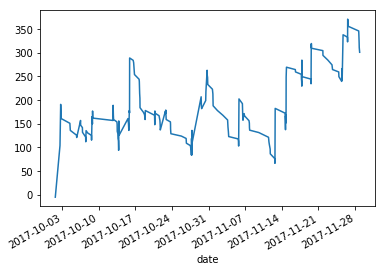

In [297]:
import matplotlib
%matplotlib inline
bets['stash'].plot()

bets

In [187]:
print(bets['date'].min(), bets['date'].max(), len(bets))

2017-10-01 16:15:00 2017-11-28 21:27:00 138


In [112]:
print(bets[bets['profit']<0]['pred_1'].describe())
print(bets[bets['profit']<0]['pred_2'].describe())
print(bets[bets['profit']<0]['pred_3'].describe())

count    99.000000
mean      0.183636
std       0.064792
min       0.100000
25%       0.140000
50%       0.166667
75%       0.213333
max       0.413333
Name: pred_1, dtype: float64
count    99.000000
mean      0.120727
std       0.038290
min       0.080000
25%       0.093333
50%       0.106667
75%       0.140000
max       0.253333
Name: pred_2, dtype: float64
count    99.000000
mean      0.094613
std       0.034937
min       0.053333
25%       0.066667
50%       0.086667
75%       0.113333
max       0.240000
Name: pred_3, dtype: float64


0.22164948453608246